# NBA_Front_Office_Optimization
Optimizing basketball team performance under a salary cap


## Project Goal
Optimize NBA salary cap allocation for a NBA franchise to maximize team performance (winning games) subject to budget constraints imposed by the salary cap.

## Background: 
NBA teams have one goal. They want to win a championship. In order to do that, they want to build the best team by picking the combination of players that increases their odds of winning. They’re constrained by a salary cap which places a limit on the total amount of money they can pay the players on their team. The other team building constraint is each roster must contain at least one player of each of the five main positions (point guard, shooting guard, small forward, power forward, and center). 

Chances of winnings is a variable that we concern. For people who are familar with NBA games probably know, there exists player statistics such as [win shares(WS)](https://www.basketball-reference.com/about/ws.html), [Box Plus/Minus (BPM)](https://www.basketball-reference.com/about/bpm2.html), and [value over replacement player (VORP)](https://www.basketball-reference.com/about/bpm2.html), are performance scores calculated based on each player's contribution to past games. We are going to see if there is correlation between chances of winings with these player statistics. If yes, we can use players' prior/historical stats as a presenation/expectation of chances of winnings.


## Project plan:
- Problem to solve: Pick NBA players to build a team 
- Objective:  Maximize chances of winnings 
- Constraints:
  * Salary cap : $102M 
  * Roster size : min 8, max 17 
  * Position : at least one player for each of the 5 positions (PG, SG, SF, PF, C)

## Interest Findings:
- The top 3 players in Win Shares showed up frequently in our optimal lineups (Giannis, Rudy G, Harden)
    * Giannis and Harden were the top 2 MVP vote getters as well
- Our models tended to pick a few super stars(expensive players) and supplement the roster with unknown(less expensive) players
- The Win Share based models leaned towards picking more center-position players while our second model incorporating all 3 statistics picked a more positionally-balanced roster
- The Free Agent model picked the top 4 available free agents in Win Shares


## Data sources: 
Player salary data: https://www.basketball-reference.com/contracts/players.html 

Player performance data: https://www.basketball-reference.com/leagues/NBA_2019_advanced.html


### Load Data

The datasets have been cleaned before loaded into this notebook. The data preprocessing part has been done in a separate notebook. For this notebook, we will have a quick data overview and then focus on solving optimization problems.

Here are the Data Preprocessing procedures:

- split player name and player ID into two separate columns
- remove duplicated rows
- for players who played in multiple team, combine all rows of a player into one row, therefore one row represent one unique player
- combine player salary table with player performance table (which contains player stats)



In [2]:
# Load data
using CSV
players = CSV.read("Players.csv"; header=true)
adv_stats_df = CSV.read("AdvStatsClean.csv"; header=true)
salaries_df = CSV.read("SalaryClean.csv"; header=true)

,Rank,Player,Team,19_20_Salary,20_21_Salary,21_22_Salary
,Int64,String,String,Int64,Int64⍰,Int64⍰
1,494,A.J. Hammons\\hammoaj01,MIA,350087,350087,missing
2,53,Aaron Gordon\\gordoaa01,ORL,19863636,18136364,16409091
3,326,Aaron Holiday\\holidaa01,IND,2239200,2345640,3980551
4,392,Abdel Nader\\naderab01,OKC,1618520,1752950,missing
5,446,Admiral Schofield\\schofad01,WAS,898310,1517981,1782621
6,24,Al Horford\\horfoal01,PHI,28000000,27500000,27000000
7,135,Al-Farouq Aminu\\aminual01,ORL,9258000,9720900,10183800
8,319,Alec Burks\\burksal01,PHI,2320044,missing,missing
9,455,Alen Smailagi?\\smailal01,GSW,898310,1517981,1782621


In [3]:
# shape of players table (we have 399 NBA players in total)
size(players)

(399, 31)

In [2]:
# Column names
names(players)

31-element Array{Symbol,1}:
 :Rk                   
 :Player               
 :Pos                  
 :Age                  
 :Tm                   
 :G                    
 :MP                   
 :PER                  
 Symbol("TS%")         
 Symbol("3PAr")        
 :FTr                  
 Symbol("ORB%")        
 Symbol("DRB%")        
 ⋮                     
 :OWS                  
 :DWS                  
 :WS                   
 Symbol("WS/48")       
 :OBPM                 
 :DBPM                 
 :BPM                  
 :VORP                 
 :Player_Name          
 :Player_ID            
 :Remove               
 Symbol("19_20_Salary")

### Data Exploratory Analysis

In general, we see there is upward trend in the scatter plots between the 3 player stats (WS, VORP, BPM) and salary. We can assume that there is a positive linear relationship (correlation) between these player stats and salary. We will later run a linear regressin model to prove this correlation.

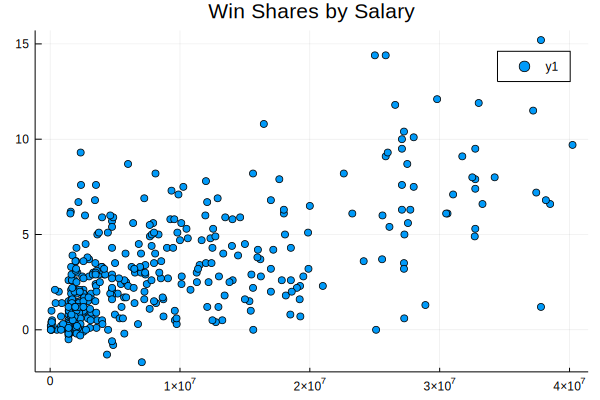

In [4]:
# Scatter plot : win shares vs salary
using Plots
scatter(players[!, Symbol("19_20_Salary")], players[!, :WS], title="Win Shares by Salary")

In [5]:
# Save the plot
savefig("WSvSal.png")

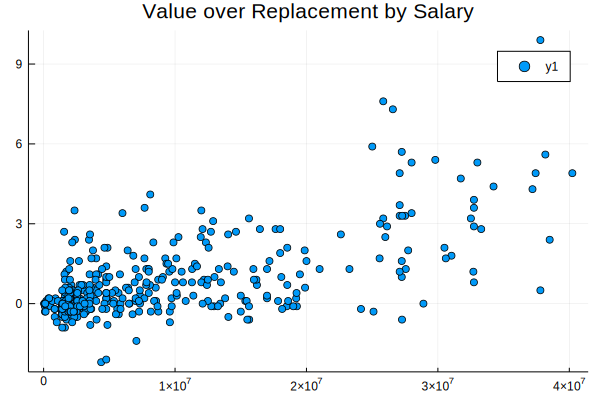

In [6]:
# Scatter plot : Value over Replacement Player (VORP) vs salary
scatter(players[!, Symbol("19_20_Salary")], players[!, :VORP], title="Value over Replacement by Salary")

In [7]:
savefig("VORPvSal.png")

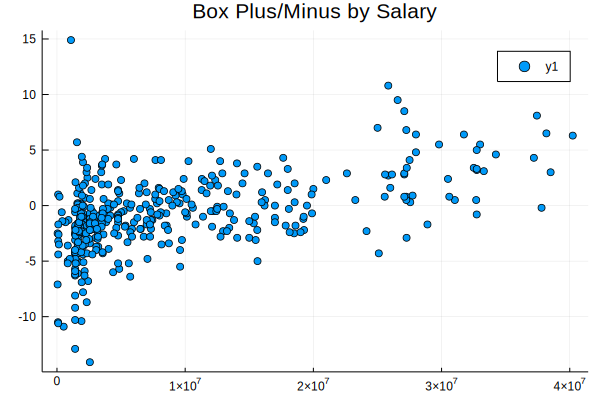

In [8]:
# Scatter plot : Box Plus/Minus (BPM) vs salary
scatter(players[!, Symbol("19_20_Salary")], players[!, :BPM], title="Box Plus/Minus by Salary")

In [9]:
savefig("BPMvSal.png")

In [4]:
# We will be using salary for the season of 2019-2020
using DataFrames
rename!(players, Dict(Symbol("19_20_Salary") => "Salary"))

,Rk,Player,Pos,Age,Tm,G,MP,PER
,Int64,String,String,Int64,String,Int64,Int64,Float64
1,3,Jaylen Adams\\adamsja01,PG,22,ATL,34,428,7.6
2,4,Steven Adams\\adamsst01,C,25,OKC,80,2669,18.5
3,5,Bam Adebayo\\adebaba01,C,21,MIA,82,1913,17.9
4,8,LaMarcus Aldridge\\aldrila01,C,33,SAS,81,2687,22.9
5,10,Grayson Allen\\allengr01,SG,23,UTA,38,416,7.5
6,11,Jarrett Allen\\allenja01,C,20,BRK,80,2096,18.5
7,13,Al-Farouq Aminu\\aminual01,PF,28,POR,81,2292,13.2
8,14,Justin Anderson\\anderju01,SF,25,ATL,48,463,11.2
9,15,Kyle Anderson\\anderky01,SF,25,MEM,43,1281,12.8


In [10]:
# important columns: player-id, position, salary, WS(winshare), BPM and VORP
players[:, [:Player,:Pos, :Salary,:WS,:BPM,:VORP]]

,Player,Pos,Salary,WS,BPM,VORP
,String,String,Int64,Float64,Float64,Float64
1,Jaylen Adams\\adamsja01,PG,100000,0.1,-4.4,-0.3
2,Steven Adams\\adamsst01,C,25842697,9.1,2.7,3.2
3,Bam Adebayo\\adebaba01,C,3454080,6.8,3.0,2.4
4,LaMarcus Aldridge\\aldrila01,C,26000000,9.3,1.6,2.5
5,Grayson Allen\\allengr01,SG,2429400,0.0,-6.8,-0.5
6,Jarrett Allen\\allenja01,C,2376840,7.6,2.5,2.4
7,Al-Farouq Aminu\\aminual01,PF,9258000,5.8,0.9,1.7
8,Justin Anderson\\anderju01,SF,98144,0.4,-3.2,-0.1
9,Kyle Anderson\\anderky01,SF,9073050,2.7,1.2,1.0


In [5]:
using GLM, StatsModels
linearmodel_ws = fit(LinearModel, @formula(WS ~ Salary), players)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

WS ~ 1 + Salary

Coefficients:
───────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error   t value  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  1.25688     0.148903     8.44096    <1e-15  0.964144    1.54962   
Salary       1.96455e-7  1.15782e-8  16.9676     <1e-48  1.73692e-7  2.19217e-7
───────────────────────────────────────────────────────────────────────────────

In [6]:
# Coefficient of Win shares
ws_coef = coef(linearmodel_ws)[2]

1.9645459381741025e-7

In [7]:
using GLM, StatsModels
linearmodel_bpm = fit(LinearModel, @formula(BPM ~ Salary), players)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

BPM ~ 1 + Salary

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                Estimate  Std. Error   t value  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -2.46515     0.200884    -12.2715    <1e-28  -2.86008    -2.07022   
Salary        1.89989e-7  1.56201e-8   12.1631    <1e-28   1.5928e-7   2.20697e-7
─────────────────────────────────────────────────────────────────────────────────

In [8]:
# Coeffiecient of BPM
bpm_coef = coef(linearmodel_bpm)[2]

1.89988777687097e-7

In [9]:
using GLM, StatsModels
linearmodel_vorp = fit(LinearModel, @formula(VORP ~ Salary), players)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

VORP ~ 1 + Salary

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                Estimate  Std. Error   t value  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.103755    0.0756915   -1.37076    0.1712  -0.252561    0.0450513 
Salary        1.00664e-7  5.88553e-9  17.1036     <1e-48   8.90934e-8  1.12235e-7
─────────────────────────────────────────────────────────────────────────────────

In [10]:
# coefficient of VORP
vorp_coef = coef(linearmodel_vorp)[2]

1.0066406843422991e-7

#### Some fun facts in the data 

The highest salary in the table is $40M

In [11]:
# The highest salary in the table
maximum(players.:Salary)

40231758

Stephen Curry is the one with the highest salary

In [12]:
# Player of the highest salary
players[players.:Salary .== 40231758, : ]

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%
,Int64,String,String,Int64,String,Int64,Int64,Float64,Float64⍰
1,124,Stephen Curry\\curryst01,PG,30,GSW,69,2331,24.4,0.641


There are a total of 399 players 

In [13]:
using DataFrames
nplayers = size(players)[1]
nplayers

399

Five positions of players in basketball game

In [14]:
unique(players.:Pos)

5-element Array{String,1}:
 "PG"
 "C" 
 "SG"
 "PF"
 "SF"

In [15]:
# Create player groups based on the position they play
PG = [i for i=1:size(players)[1] if players[i,:Pos] .== "PG" ]
C = [i for i=1:size(players)[1] if players[i,:Pos] .== "C" ]
SG = [i for i=1:size(players)[1] if players[i,:Pos] .== "SG" ]
PF = [i for i=1:size(players)[1] if players[i,:Pos] .== "PF" ]
SF = [i for i=1:size(players)[1] if players[i,:Pos] .== "SF" ]

67-element Array{Int64,1}:
   8
   9
  13
  15
  24
  25
  26
  42
  49
  50
  53
  57
  64
   ⋮
 309
 319
 329
 334
 347
 351
 377
 379
 383
 385
 389
 391

## Optimization Models

### Model 1 - Maximize Win shares
We consider win shares as the only objective to maximize

In [16]:
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface


model  = Model(with_optimizer(GLPK.Optimizer))

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model, x[1:399], Bin)
 
# each cell must contain only one digit
@constraint(model, sum(x[i] for i in PG) >= 1)
@constraint(model, sum(x[i] for i in C) >= 1)
@constraint(model, sum(x[i] for i in SG) >= 1)
@constraint(model, sum(x[i] for i in PF) >= 1)
@constraint(model, sum(x[i] for i in SF) >= 1)
@constraint(model, sum(x[i] for i in 1:399) == 8)
@constraint(model, sum(x[i] .* players[i,:Salary] for i = 1:399) <=  102000000)  


# maximize win shares    
@objective(model, Max, sum(x[i] .* players[i,:WS] for i = 1:399))
                    

println("The optimization problem to be solved is:")
print(model)

JuMP.optimize!(model)
term_status = JuMP.termination_status(model)
primal_status = JuMP.primal_status(model)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Max 0.1 x[1] + 9.1 x[2] + 6.8 x[3] + 9.3 x[4] + 7.6 x[6] + 5.8 x[7] + 0.4 x[8] + 2.7 x[9] - 0.2 x[10] + 14.4 x[11] + 0.3 x[12] + 2 x[13] + 3.7 x[14] + 2.5 x[15] + 6.9 x[16] + 5.8 x[17] + 1.2 x[18] + 3.6 x[19] + 1.6 x[20] + 1.7 x[21] + x[22] + 3.6 x[23] + 1.2 x[24] + 0.3 x[25] + 3.7 x[26] + 2.4 x[27] + 0.7 x[28] + 7.6 x[29] + 4.5 x[30] + 2.5 x[31] + 1.6 x[32] + 0.9 x[33] + 0.5 x[34] + 4 x[35] + 4.8 x[36] + 2.8 x[37] + 2 x[38] + 4.5 x[39] + 8.2 x[40] + 2.7 x[41] + 6.8 x[42] + 1.4 x[43] - 0.1 x[44] + 3.5 x[45] + 0.7 x[46] + 0.3 x[47] + 0.1 x[48] + 2.9 x[49] + 2.9 x[50] + 0.8 x[51] + 6.5 x[52] + 1.5 x[54] + 3 x[55] + 2.1 x[56] + 0.6 x[57] + 2.6 x[58] + 5.6 x[59] + 3.1 x[60] + 1.9 x[61] + 1.5 x[62] + 0.1 x[63] + 7.9 x[64] + 1.5 x[65] + 4 x[66] + 10.8 x[67] + 3.1 x[68] + 1.9 x[70] + 1.9 x[71] + 0.8 x[72] + x[73] + 6.7 x[74] + 2.1 x[75] + 1.5 x[76] - 0.2 x[77] + x[78] + 1.8 x[79] + 6 x[80] + 2.9 x[81] + 8 x[82] + 3.9 x[83] + 1.8 x[84] + 2.4 x[85] + 2.

true

In [17]:
println("Objective value: ", objective_value(model))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 78.39999999999999
Optimal solution is x = 
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [18]:
players[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :Salary]]

,Player,Pos,WS,Salary
,String,String,Float64,Int64
1,Jarrett Allen\\allenja01,C,7.6,2376840
2,Giannis Antetokounmpo\\antetgi01,PF,14.4,25842697
3,Paul George\\georgpa01,SF,11.9,33005556
4,Rudy Gobert\\goberru01,C,14.4,25008427
5,Montrezl Harrell\\harremo01,C,8.7,6000000
6,Buddy Hield\\hieldbu01,SG,5.9,4861208
7,Monte Morris\\morrimo01,PG,6.2,1588231
8,Pascal Siakam\\siakapa01,PF,9.3,2351839


In [19]:
sum(players[JuMP.value.(x) .== 1.0, :Salary])


101034798

### Model 2 -  Maximize Weighted Avg. of WS, BPM and VORP
Maximize chances of winnings , that is weighted average of WS, VORP and BPM with coefficients from the linear regression model

In [20]:
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface


model_2  = Model(with_optimizer(GLPK.Optimizer))

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model_2, x[1:399], Bin)
 
# each cell must contain only one digit
@constraint(model_2, sum(x[i] for i in PG) >= 1)
@constraint(model_2, sum(x[i] for i in C) >= 1)
@constraint(model_2, sum(x[i] for i in SG) >= 1)
@constraint(model_2, sum(x[i] for i in PF) >= 1)
@constraint(model_2, sum(x[i] for i in SF) >= 1)
@constraint(model_2, sum(x[i] for i in 1:399) == 8)
@constraint(model_2, sum(x[i] .* players[i,:Salary] for i = 1:399) <=  102000000)  


# maximize combination of win shares, VORP, and BPM  
@objective(model_2, Max, sum(x[i] .* (ws_coef .* players[i,:WS] .+ vorp_coef .* players[i,:VORP] .+ bpm_coef .* players[i,:BPM])  for i = 1:399))
                    

println("The optimization problem to be solved is:")
print(model_2)

JuMP.optimize!(model_2)
term_status = JuMP.termination_status(model_2)
primal_status = JuMP.primal_status(model_2)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Max -8.465043829717548e-7 x[1] + 2.622831522483131e-6 x[2] + 2.1474513352618327e-6 x[3] + 2.382669937886846e-6 x[4] - 1.3422557224893747e-6 x[5] + 2.209620621472212e-6 x[6] + 1.4815554603975574e-6 x[7] - 5.394486579151694e-7 x[8] + 8.59078004965754e-7 x[9] - 1.295484723334595e-6 x[10] + 5.645871870091503e-6 x[11] - 1.0921966307389185e-6 x[12] + 1.9512187494057306e-7 x[13] + 5.87225253654436e-7 x[14] + 4.86739757290784e-7 x[15] + 1.3992041324682316e-6 x[16] + 1.2982312817994746e-6 x[17] - 4.5941442985421624e-7 x[18] + 3.7532314474932523e-7 x[19] + 4.999194005422119e-7 x[20] + 3.3624068132587e-7 x[21] + 7.599752048449506e-9 x[22] + 2.5012953537550785e-7 x[23] - 2.1129508294285378e-7 x[24] - 5.400952395282008e-7 x[25] + 1.0500019356122863e-6 x[26] + 5.59820814916319e-7 x[27] - 2.905235020828493e-7 x[28] + 2.39748054374284e-6 x[29] + 8.595161312387585e-7 x[30] + 9.216005140062189e-8 x[31] + 2.6853105956328656e-7 x[32] - 2.5123258331936727e-7 x[33] 

true

In [21]:
println("Objective value: ", objective_value(model_2))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 2.7180531772539608e-5
Optimal solution is x = 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [22]:
players[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :BPM,:VORP, :Salary]]

,Player,Pos,WS,BPM,VORP,Salary
,String,String,Float64,Float64,Float64,Int64
1,Giannis Antetokounmpo\\antetgi01,PF,14.4,10.8,7.6,25842697
2,Rudy Gobert\\goberru01,C,14.4,7.0,5.9,25008427
3,James Harden\\hardeja01,PG,15.2,11.7,9.9,37800000
4,Buddy Hield\\hieldbu01,SG,5.9,1.1,2.1,4861208
5,Royce O'Neale\\onealro01,SF,3.3,0.1,0.9,1618520
6,Gary Payton\\paytoga02,PG,0.1,14.9,0.1,1090781
7,Mitchell Robinson\\robinmi01,C,6.1,5.7,2.7,1559712
8,Pascal Siakam\\siakapa01,PF,9.3,3.4,3.5,2351839


In [23]:
sum(players[JuMP.value.(x) .== 1.0, :Salary])


100133184

### Model 3 - Maximize sum of WS, BPM and VORP

Maximize chances of winnings, which is the simple sum of WS, BPM and VORP

In [24]:
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface


model_3  = Model(with_optimizer(GLPK.Optimizer))

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model_3, x[1:399], Bin)
 
# each cell must contain only one digit
@constraint(model_3, sum(x[i] for i in PG) >= 1)
@constraint(model_3, sum(x[i] for i in C) >= 1)
@constraint(model_3, sum(x[i] for i in SG) >= 1)
@constraint(model_3, sum(x[i] for i in PF) >= 1)
@constraint(model_3, sum(x[i] for i in SF) >= 1)
@constraint(model_3, sum(x[i] for i in 1:399) == 8)
@constraint(model_3, sum(x[i] .* players[i,:Salary] for i = 1:399) <=  102000000)  


# maximize win shares plus VORP plus BPM   
@objective(model_3, Max, sum(x[i] .* ( players[i,:WS] .+ players[i,:VORP] .+  players[i,:BPM])  for i = 1:399))
                    

println("The optimization problem to be solved is:")
print(model_3)

JuMP.optimize!(model_3)
term_status = JuMP.termination_status(model_3)
primal_status = JuMP.primal_status(model_3)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Max -4.6000000000000005 x[1] + 15 x[2] + 12.2 x[3] + 13.4 x[4] - 7.3 x[5] + 12.5 x[6] + 8.4 x[7] - 2.9000000000000004 x[8] + 4.9 x[9] - 7 x[10] + 32.8 x[11] - 5.9 x[12] + 1.0999999999999999 x[13] + 3.2 x[14] + 2.9 x[15] + 7.6000000000000005 x[16] + 7.2 x[17] - 2.6 x[18] + 1.9000000000000001 x[19] + 3 x[20] + 1.9000000000000001 x[21] + 0.09999999999999987 x[22] + 1.1 x[23] - 1.2 x[24] - 2.9 x[25] + 6.2 x[26] + 3.1 x[27] - 1.6 x[28] + 14.100000000000001 x[29] + 4.7 x[30] + 0.3999999999999999 x[31] + 1.5 x[32] - 1.4000000000000001 x[33] - 3.1999999999999997 x[34] + 6.5 x[35] + 9.399999999999999 x[36] + 5.9 x[37] + 1.1 x[38] + 8.3 x[39] + 14.899999999999999 x[40] + 2.6000000000000005 x[41] + 8.1 x[42] + 3.0999999999999996 x[43] - 4.5 x[44] + 5.8999999999999995 x[45] + 1.9 x[46] - 2.9 x[47] - 0.6 x[48] + 3.8 x[49] + 2.9 x[50] - 1.4999999999999998 x[51] + 9.6 x[52] - 6.3999999999999995 x[53] - 0.5 x[54] + 0.8999999999999999 x[55] + 0.6000000000000001

true

In [25]:
println("Objective value: ", objective_value(model_3))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 157.39999999999998
Optimal solution is x = 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [26]:
players[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :BPM,:VORP, :Salary]]

,Player,Pos,WS,BPM,VORP,Salary
,String,String,Float64,Float64,Float64,Int64
1,Giannis Antetokounmpo\\antetgi01,PF,14.4,10.8,7.6,25842697
2,James Harden\\hardeja01,PG,15.2,11.7,9.9,37800000
3,Buddy Hield\\hieldbu01,SG,5.9,1.1,2.1,4861208
4,Nikola Joki?\\jokicni01,C,11.8,9.5,7.3,26573595
5,Royce O'Neale\\onealro01,SF,3.3,0.1,0.9,1618520
6,Gary Payton\\paytoga02,PG,0.1,14.9,0.1,1090781
7,Mitchell Robinson\\robinmi01,C,6.1,5.7,2.7,1559712
8,Pascal Siakam\\siakapa01,PF,9.3,3.4,3.5,2351839


In [27]:
sum(players[JuMP.value.(x) .== 1.0, :Salary])

101698352

### Model 4 - dual problem
**Minimize** salary for the optimal level of total win shares


All optimization problems can be viewed from two perspectives, the Primal and the Dual problems. Their definitions will be inverses of each other but find the same solution
In our Primal problem, we maximized team performance under the salary cap constraint
In the Dual, we minimized salary needed to achieve a threshold value of performance


In [32]:
# dual problem: minimize salary for the optimal level of total win shares
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface

minws = 78.39

model_dual  = Model(with_optimizer(GLPK.Optimizer))

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model_dual, x[1:399], Bin)
 
# each cell must contain only one digit
@constraint(model_dual, sum(x[i] for i in PG) >= 1)
@constraint(model_dual, sum(x[i] for i in C) >= 1)
@constraint(model_dual, sum(x[i] for i in SG) >= 1)
@constraint(model_dual, sum(x[i] for i in PF) >= 1)
@constraint(model_dual, sum(x[i] for i in SF) >= 1)
@constraint(model_dual, sum(x[i] for i in 1:399) == 8)
@constraint(model_dual, sum(x[i] .* players[i,:WS] for i = 1:399) >= minws)  


# minimize salary
@objective(model_dual, Min, sum(x[i] .* players[i,:Salary] for i = 1:399))
                    

println("The optimization problem to be solved is:")
print(model_dual)

JuMP.optimize!(model_dual)
term_status = JuMP.termination_status(model_dual)
primal_status = JuMP.primal_status(model_dual)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Min 100000 x[1] + 2.5842697e7 x[2] + 3.45408e6 x[3] + 2.6e7 x[4] + 2.4294e6 x[5] + 2.37684e6 x[6] + 9.258e6 x[7] + 98144 x[8] + 9.07305e6 x[9] + 5.714583e6 x[10] + 2.5842697e7 x[11] + 2.159029e6 x[12] + 2.2818e6 x[13] + 3.0e6 x[14] + 1.22e7 x[15] + 7.25e6 x[16] + 9.56292e6 x[17] + 1.61852e6 x[18] + 8.55612e6 x[19] + 8.71932e6 x[20] + 5.6976e6 x[21] + 2.564753e6 x[22] + 2.4147727e7 x[23] + 1.296e7 x[24] + 1.416852e6 x[25] + 2.5565217e7 x[26] + 5.45328e6 x[27] + 1.9269662e7 x[28] + 2.7093019e7 x[29] + 2.731714e6 x[30] + 5.846154e6 x[31] + 1.620564e6 x[32] + 2.603982e6 x[33] + 1.678854e6 x[34] + 7.0e6 x[35] + 1.2345679e7 x[36] + 3.0e6 x[37] + 1.7e7 x[38] + 6.825e6 x[39] + 1.5625e7 x[40] + 8.529386e6 x[41] + 1.7e7 x[42] + 1.780128e6 x[43] + 1.416852e6 x[44] + 2.725e7 x[45] + 1.588231e6 x[46] + 6.767e6 x[47] + 1.96236e6 x[48] + 4.161e6 x[49] + 3.7554e6 x[50] + 1.443842e6 x[51] + 2.0e7 x[52] + 1.61852e6 x[53] + 1.416852e6 x[54] + 6.534829e6 x[55] + 1

true

In [33]:
println("Objective value: ", objective_value(model_dual))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 1.01034798e8
Optimal solution is x = 
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [34]:
players[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :Salary]]

,Player,Pos,WS,Salary
,String,String,Float64,Int64
1,Jarrett Allen\\allenja01,C,7.6,2376840
2,Giannis Antetokounmpo\\antetgi01,PF,14.4,25842697
3,Paul George\\georgpa01,SF,11.9,33005556
4,Rudy Gobert\\goberru01,C,14.4,25008427
5,Montrezl Harrell\\harremo01,C,8.7,6000000
6,Buddy Hield\\hieldbu01,SG,5.9,4861208
7,Monte Morris\\morrimo01,PG,6.2,1588231
8,Pascal Siakam\\siakapa01,PF,9.3,2351839


Woo same team as max win shares team!

### Model 5 - Dual problem (moderate performance)
What if we want to **minimize** salary for some **acceptable (medium)** level of performances?

In model 4, we minimized salary but want to achieve the optimal value of our objective (as high as our base model), and the resulting players are the same as the base model as we maximize winning chances while subject to a salary cap. Here what we try to experiment with is to see what a team looks like if we want a just-fine team(moderate performance)

In [35]:
# dual problem: minimize salary for some lower level of total win shares
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface

minws = 70

model_dual  = Model(with_optimizer(GLPK.Optimizer))

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model_dual, x[1:399], Bin)
 
# each cell must contain only one digit
@constraint(model_dual, sum(x[i] for i in PG) >= 1)
@constraint(model_dual, sum(x[i] for i in C) >= 1)
@constraint(model_dual, sum(x[i] for i in SG) >= 1)
@constraint(model_dual, sum(x[i] for i in PF) >= 1)
@constraint(model_dual, sum(x[i] for i in SF) >= 1)
@constraint(model_dual, sum(x[i] for i in 1:399) == 8)
@constraint(model_dual, sum(x[i] .* players[i,:WS] for i = 1:399) >= minws)  


# minimize salary   
@objective(model_dual, Min, sum(x[i] .* players[i,:Salary] for i = 1:399))
                    

println("The optimization problem to be solved is:")
print(model_dual)

JuMP.optimize!(model_dual)
term_status = JuMP.termination_status(model_dual)
primal_status = JuMP.primal_status(model_dual)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Min 100000 x[1] + 2.5842697e7 x[2] + 3.45408e6 x[3] + 2.6e7 x[4] + 2.4294e6 x[5] + 2.37684e6 x[6] + 9.258e6 x[7] + 98144 x[8] + 9.07305e6 x[9] + 5.714583e6 x[10] + 2.5842697e7 x[11] + 2.159029e6 x[12] + 2.2818e6 x[13] + 3.0e6 x[14] + 1.22e7 x[15] + 7.25e6 x[16] + 9.56292e6 x[17] + 1.61852e6 x[18] + 8.55612e6 x[19] + 8.71932e6 x[20] + 5.6976e6 x[21] + 2.564753e6 x[22] + 2.4147727e7 x[23] + 1.296e7 x[24] + 1.416852e6 x[25] + 2.5565217e7 x[26] + 5.45328e6 x[27] + 1.9269662e7 x[28] + 2.7093019e7 x[29] + 2.731714e6 x[30] + 5.846154e6 x[31] + 1.620564e6 x[32] + 2.603982e6 x[33] + 1.678854e6 x[34] + 7.0e6 x[35] + 1.2345679e7 x[36] + 3.0e6 x[37] + 1.7e7 x[38] + 6.825e6 x[39] + 1.5625e7 x[40] + 8.529386e6 x[41] + 1.7e7 x[42] + 1.780128e6 x[43] + 1.416852e6 x[44] + 2.725e7 x[45] + 1.588231e6 x[46] + 6.767e6 x[47] + 1.96236e6 x[48] + 4.161e6 x[49] + 3.7554e6 x[50] + 1.443842e6 x[51] + 2.0e7 x[52] + 1.61852e6 x[53] + 1.416852e6 x[54] + 6.534829e6 x[55] + 1

true

In [36]:
println("Objective value: ", objective_value(model_dual))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 7.3388797e7
Optimal solution is x = 
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [37]:
players[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :Salary]]

,Player,Pos,WS,Salary
,String,String,Float64,Int64
1,Jarrett Allen\\allenja01,C,7.6,2376840
2,Giannis Antetokounmpo\\antetgi01,PF,14.4,25842697
3,Rudy Gobert\\goberru01,C,14.4,25008427
4,Buddy Hield\\hieldbu01,SG,5.9,4861208
5,Monte Morris\\morrimo01,PG,6.2,1588231
6,Domantas Sabonis\\sabondo01,C,7.6,3529555
7,Pascal Siakam\\siakapa01,PF,9.3,2351839
8,Jayson Tatum\\tatumja01,SF,5.0,7830000


In [38]:
sum(players[JuMP.value.(x) .== 1.0, :Salary])

73388797

In [39]:
sum(players[JuMP.value.(x) .== 1.0, :WS])

70.4

### Model 7 : free agents only
Right now we are playing the real-game as we only consider free agents players (those who are available on the market).

In [5]:
players[:, Symbol("20_21_Salary")] .= 0.0

399-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [6]:
players[:, :freeAgent] .= 0

399-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [7]:
for i in 1:nrow(players)
    nextYearSalary = salaries_df[in.(salaries_df.Player, Ref([players[i, :Player]])), Symbol("20_21_Salary")]
    if ismissing(nextYearSalary[1])
        players[i, :freeAgent] = 1
    end
end

In [8]:
freeAgents = players[(players[:freeAgent].==1),:]
freeAgents

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[8]:1
└ @ Core In[8]:1


,Rk,Player,Pos,Age,Tm,G,MP
,Int64,String,String,Int64,String,Int64,Int64
1,3,Jaylen Adams\\adamsja01,PG,22,ATL,34,428
2,14,Justin Anderson\\anderju01,SF,25,ATL,48,463
3,20,Carmelo Anthony\\anthoca01,PF,34,HOU,10,294
4,24,D.J. Augustin\\augusdj01,PG,31,ORL,81,2269
5,26,Dwayne Bacon\\bacondw01,SG,23,CHO,43,759
6,32,J.J. Barea\\bareajo01,PG,34,DAL,38,752
7,38,Aron Baynes\\baynear01,C,32,BOS,51,821
8,39,Kent Bazemore\\bazemke01,SG,29,ATL,67,1643
9,41,Malik Beasley\\beaslma01,SG,22,DEN,81,1879


In [9]:
faPG = [i for i=1:size(freeAgents)[1] if freeAgents[i,:Pos] .== "PG" ]
faC = [i for i=1:size(freeAgents)[1] if freeAgents[i,:Pos] .== "C" ]
faSG = [i for i=1:size(freeAgents)[1] if freeAgents[i,:Pos] .== "SG" ]
faPF = [i for i=1:size(freeAgents)[1] if freeAgents[i,:Pos] .== "PF" ]
faSF = [i for i=1:size(freeAgents)[1] if freeAgents[i,:Pos] .== "SF" ]

18-element Array{Int64,1}:
   2
  24
  36
  37
  48
  56
  65
  67
  70
  71
  79
  80
  95
  96
 107
 116
 118
 134

In [15]:
using JuMP, GLPK, Test
const MOI = JuMP. MathOptInterface


model_fa  = Model(GLPK.Optimizer)

#  When X[i] == 1, the player is selected, 0 not selected
@variable(model_fa, x[1:138], Bin)
 
# each cell must contain only one digit
@constraint(model_fa, sum(x[i] for i in faPG) >= 1)
@constraint(model_fa, sum(x[i] for i in faC) >= 1)
@constraint(model_fa, sum(x[i] for i in faSG) >= 1)
@constraint(model_fa, sum(x[i] for i in faPF) >= 1)
@constraint(model_fa, sum(x[i] for i in faSF) >= 1)
@constraint(model_fa, sum(x[i] for i in 1:138) == 8)
@constraint(model_fa, sum(x[i] .* freeAgents[i,:Salary] for i = 1:138) <=  102000000)  


# maximize win shares    
@objective(model_fa, Max, sum(x[i] .* freeAgents[i,:WS] for i = 1:138))
                    

println("The optimization problem to be solved is:")
print(model_fa)

JuMP.optimize!(model_fa)
term_status = JuMP.termination_status(model_fa)
primal_status = JuMP.primal_status(model_fa)
is_optimal = term_status == MOI.OPTIMAL

The optimization problem to be solved is:
Max 0.1 x[1] + 0.4 x[2] + 0.3 x[3] + 6.9 x[4] + 1.2 x[5] + x[6] + 2.4 x[7] + 0.7 x[8] + 4.5 x[9] + 2.5 x[10] + 1.6 x[11] + 0.9 x[12] + 0.5 x[13] + 4 x[14] + 2 x[15] + 2.7 x[16] + 1.4 x[17] + 0.7 x[18] + 0.8 x[19] + 2.1 x[20] + 1.9 x[21] + 1.5 x[22] + 0.1 x[23] + 1.5 x[24] + 1.9 x[26] + 0.8 x[27] + 2.1 x[28] + 1.5 x[29] - 0.2 x[30] + x[31] + 1.8 x[32] + 3.9 x[33] + 2.4 x[34] + 0.8 x[35] + 3 x[36] + 4.4 x[37] + 0.3 x[38] + 0.5 x[39] + 1.5 x[40] + 1.6 x[41] + 1.8 x[42] + 0.6 x[43] + 7.9 x[44] + 1.9 x[45] + 3.8 x[46] + 2 x[47] + 8.2 x[48] + 3.4 x[49] + 6 x[50] + 1.1 x[51] + x[52] + 0.5 x[53] + 1.9 x[54] + 3.6 x[55] + 3.4 x[56] + 8.7 x[57] + 5.5 x[58] + 1.4 x[59] - 0.1 x[60] + 0.6 x[61] + 3 x[62] + 2.6 x[63] + 1.4 x[64] + 0.5 x[65] + 2.1 x[66] + 1.2 x[67] + 0.6 x[68] + 6.1 x[69] + 2 x[70] + 1.9 x[71] + 0.4 x[72] - 1.7 x[73] + 5 x[74] + 0.4 x[75] + 2.3 x[77] + 1.5 x[78] + 2.9 x[79] + 0.2 x[80] + 2.5 x[81] + 2.3 x[83] + 0.3 x[84] + 0.4 x[85] + 3.2 x[8

true

In [16]:
println("Objective value: ", objective_value(model_fa))
println("Optimal solution is x = \n", JuMP.value.(x))

Objective value: 52.900000000000006
Optimal solution is x = 
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
freeAgents[JuMP.value.(x) .== 1.0, [:Player, :Pos, :WS, :Salary]]

,Player,Pos,WS,Salary
,String,String,Float64,Int64
1,D.J. Augustin\\augusdj01,PG,6.9,7250000
2,Malik Beasley\\beaslma01,SG,4.5,2731714
3,Derrick Favors\\favorde01,C,7.9,17650000
4,Danilo Gallinari\\gallida01,SF,8.2,22615559
5,Montrezl Harrell\\harremo01,C,8.7,6000000
6,Joe Harris\\harrijo01,SG,5.5,7670000
7,Paul Millsap\\millspa01,PF,6.1,30500000
8,Jakob P\xf6ltl\\poeltja01,C,5.1,3754886


In [18]:
sum(freeAgents[JuMP.value.(x) .== 1.0, :Salary])

98172159

In [19]:
sum(freeAgents[JuMP.value.(x) .== 1.0, :WS])

52.900000000000006